# Opcode Frequency Extraction

## Setup

In [1]:
import os
import pandas as pd
from pathlib import Path
import json
import re

from collections import Counter
import matplotlib.pyplot as plt
from evmdasm import EvmBytecode

In [2]:
PATH = Path.cwd().parents[1]
DATA_PATH = os.path.join(PATH, 'data')
NAME = 'crpwarner'
IN_PATH = os.path.join(DATA_PATH, f'external/{NAME}/groundtruth/hex')
OUT_PATH = os.path.join(DATA_PATH, f'interim/{NAME}')
PRO_PATH = os.path.join(DATA_PATH, 'processed/opcode_freq')
df = pd.read_csv(os.path.join(OUT_PATH, 'dataset-modified.csv')).set_index('address')

## Load Bytecode

In [3]:
def load_bytecode(file_path):
    with open(file_path, 'r') as f:
        return f.read().strip()


## Disassemble to Opcode List

In [4]:
def get_opcodes(bytecode):
    evm_code = EvmBytecode(bytecode)
    opcodes = []
    for instr in evm_code.disassemble():
        opcode = instr.name
        # Extract the first alphanumeric-only word (no digits, no special characters)
        match = re.match(r'^[a-zA-Z]+', opcode)

        if match:
            opcode_group = match.group()
            opcodes.append(opcode_group)
        else:
            opcodes.append(opcode)
    return opcodes


## Compute Frequency per Contract

In [5]:
def opcode_freq_from_file(hex_file):
    bytecode = load_bytecode(hex_file)
    opcodes = get_opcodes(bytecode)
    return dict(Counter(opcodes))


## Build Dataset

In [6]:
hex_dir = Path(IN_PATH)
all_files = list(hex_dir.glob('*.hex'))

records = []
for file in all_files:
    freq = opcode_freq_from_file(file)
    freq['address'] = file.stem.lower()
    records.append(freq)

feature_df = pd.DataFrame(records).fillna(0).set_index('address')

invalid instruction: PUSH30
invalid instruction: PUSH16
invalid instruction: PUSH30
invalid instruction: PUSH24
invalid instruction: PUSH30
invalid instruction: PUSH16
invalid instruction: PUSH15
invalid instruction: PUSH13
invalid instruction: PUSH31
invalid instruction: PUSH25
invalid instruction: PUSH16
invalid instruction: PUSH13
invalid instruction: PUSH25
invalid instruction: PUSH21
invalid instruction: PUSH16
invalid instruction: PUSH15
invalid instruction: PUSH19
invalid instruction: PUSH29
invalid instruction: PUSH29
invalid instruction: PUSH26
invalid instruction: PUSH20
invalid instruction: PUSH17
invalid instruction: PUSH16
invalid instruction: PUSH20
invalid instruction: PUSH13
invalid instruction: PUSH13
invalid instruction: PUSH13
invalid instruction: PUSH24
invalid instruction: PUSH27
invalid instruction: PUSH32
invalid instruction: PUSH29


## Visualize or Export

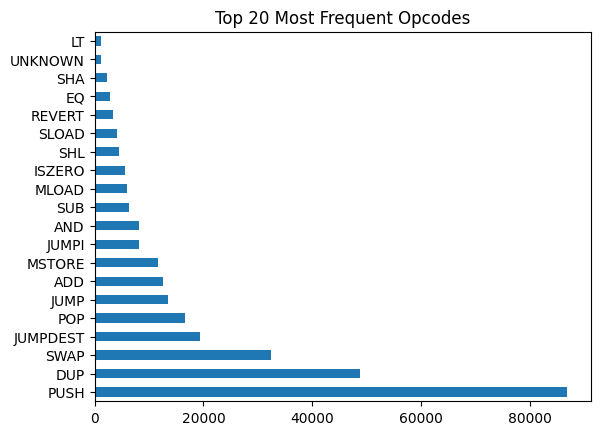

In [7]:
feature_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title("Top 20 Most Frequent Opcodes")
plt.show()

In [8]:
feature_df.to_csv(os.path.join(OUT_PATH, 'opcode_freq.csv'))

## Export Labels & Feature Columns

In [9]:
labels = list(df.columns)
features = list(feature_df.columns)
with open(os.path.join(PRO_PATH, 'labels.json'), "w") as f:
    json.dump(labels, f, indent=2)

with open(os.path.join(PRO_PATH, 'features.json'), "w") as f:
    json.dump(features, f, indent=2)

## Merge with Labels Dataframe

In [10]:
df = df.merge(feature_df, left_index=True, right_index=True)
df.select_dtypes(float).fillna(0).astype(int)
df.head()

,mint,leak,limit,PUSH,MSTORE,CALLDATASIZE,LT,JUMPI,CALLDATALOAD,SWAP,...,MULMOD,DIFFICULTY,BALANCE,BASEFEE,SDIV,CALLCODE,SGT,EXTCODECOPY,SIGNEXTEND,DELEGATECALL
address,,,,,,,,,,,,,,,,,,,,,
0x93023f1d3525e273f291b6f76d2f5027a39bf302,1,0,1,734,119.0,14,9.0,67,8.0,187,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,0,0,1,1155,179.0,23,13.0,101,7.0,264,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x94b7d24552933f50a5a5705c446528806dcea381,0,0,0,20,3.0,2,0.0,2,1.0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
0xe0b9d4146aad6936cbfcbe4dae47e34aab96b093,0,0,0,1135,107.0,9,10.0,96,3.0,464,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x10f6f2b97f3ab29583d9d38babf2994df7220c21,1,0,1,1623,150.0,18,18.0,115,6.0,722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df.to_csv(os.path.join(PRO_PATH, 'dataset.csv'))